Iteration 0: Cost = 2.69051e+00, Best Cost = 2.69051e+00
Iteration 1: Cost = 2.56813e+00, Best Cost = 2.56813e+00
Iteration 2: Cost = 2.45126e+00, Best Cost = 2.45126e+00
Iteration 3: Cost = 2.33973e+00, Best Cost = 2.33973e+00
Iteration 4: Cost = 2.23337e+00, Best Cost = 2.23337e+00
Iteration 5: Cost = 2.13198e+00, Best Cost = 2.13198e+00
Iteration 6: Cost = 2.03535e+00, Best Cost = 2.03535e+00
Iteration 7: Cost = 1.94328e+00, Best Cost = 1.94328e+00
Iteration 8: Cost = 1.85556e+00, Best Cost = 1.85556e+00
Iteration 9: Cost = 1.77196e+00, Best Cost = 1.77196e+00
Iteration 10: Cost = 1.69226e+00, Best Cost = 1.69226e+00
Iteration 11: Cost = 1.61625e+00, Best Cost = 1.61625e+00
Iteration 12: Cost = 1.54371e+00, Best Cost = 1.54371e+00
Iteration 13: Cost = 1.47442e+00, Best Cost = 1.47442e+00
Iteration 14: Cost = 1.40817e+00, Best Cost = 1.40817e+00
Iteration 15: Cost = 1.34475e+00, Best Cost = 1.34475e+00
Iteration 16: Cost = 1.28398e+00, Best Cost = 1.28398e+00
Iteration 17: Cost = 1.2

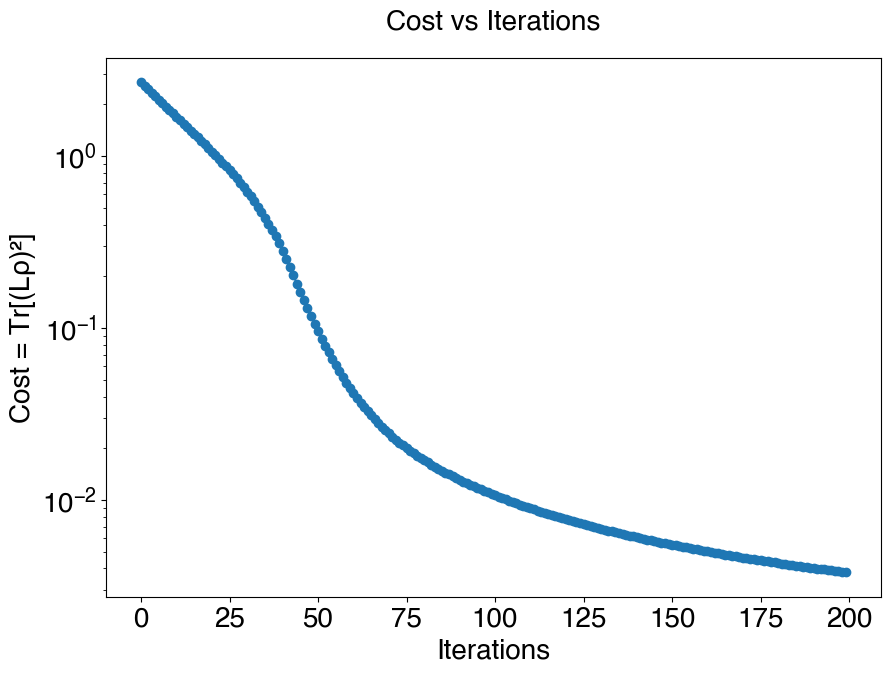

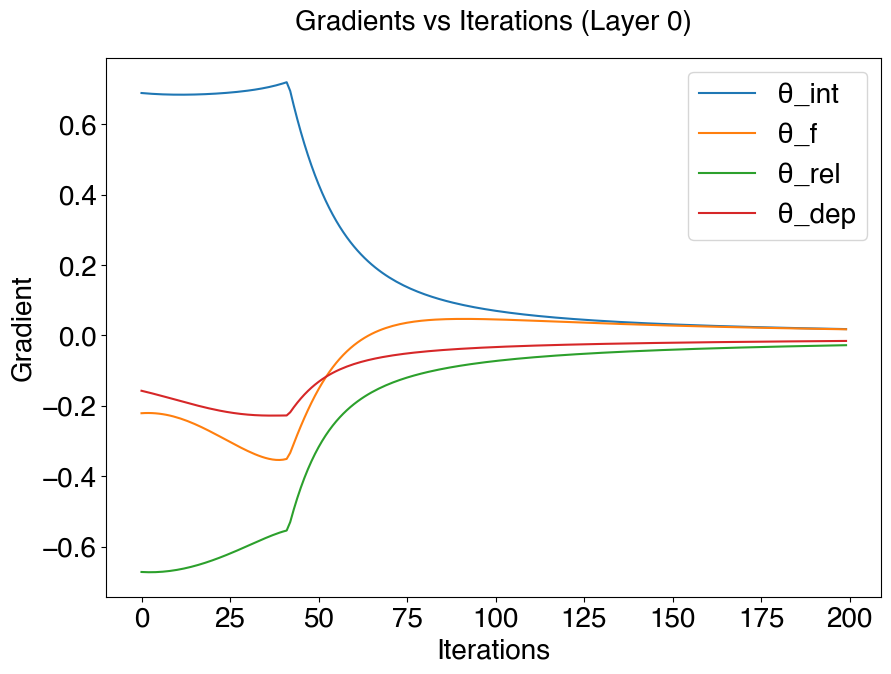

In [58]:
import numpy as np
import matplotlib.pyplot as plt
# from infinite_ranged_unitary_cost_function import VQE_Noisy_Optimizer # Import the class
from infinite_ranged_lindblad_cost_function import VQE_Noisy_Optimizer
# from infinite_ranged_unitary_cost_function_AI_2 import VQE_Noisy_Optimizer

# --- 1. Set up Matplotlib Parameters (Optional) ---
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update(params)


# --- 2. Define System and Optimization Parameters ---
# System parameters
J = 1.0
Delta = 0.6
L = 1.0
gamma = 0.5 # Set the total noise strength
gamma_e = gamma  # Set the energy relaxation noise strength
gamma_d = gamma  # Set the dephasing noise strength
gamma_depol = 0.0 # Set depolarizing noise strength

# Optimization parameters
n_layers = 1
learning_rate = 0.03
n_iterations = 200

def solution_set():
     r""" 
     Returns the exact solution set of the system.
     """
     sqrt_term = np.sqrt(gamma_e * (gamma_e + gamma_d) / (8 * J * L * Delta))
     correction_term = 1 - (16 * Delta**2 + (gamma_e + gamma_d)**2) / (16 * J * L * Delta)

     if correction_term < 0:
          x_pos = 0
          x_neg = 0
          y_pos = 0
          y_neg = 0
          z = -1
     else:
          x_pos = (4 * Delta / (gamma_e + gamma_d)) * sqrt_term * np.sqrt(correction_term)
          x_neg = -x_pos
          y_pos = sqrt_term * np.sqrt(correction_term)
          y_neg = -y_pos
          z = (-16 * Delta**2 - (gamma_e + gamma_d)**2) / (16 * J * L * Delta)
     return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

initial_angles = [2 * np.random.rand(4) - 1 for _ in range(n_layers)]

# --- 3. Instantiate and Run the Optimizer ---
# Create an instance of the optimizer with the desired system parameters
vqe_sim = VQE_Noisy_Optimizer(
    J=J, 
    Delta=Delta, 
    L=L,
    gamma_e=gamma_e, 
    gamma_d=gamma_d, 
    gamma_depol=gamma_depol
)

# Run the gradient descent optimization
optimization = vqe_sim.run_optimizer(
    n_layers=n_layers, 
    initial_angles=initial_angles, 
    learning_rate=learning_rate, 
    max_iterations=n_iterations
)


# --- 4. Plot the Results ---
# The plotting methods are now part of the class instance
vqe_sim.plot_cost_history()
vqe_sim.plot_gradient_history()

In [59]:
best_angles_, best_cost_, cost_history_, grads_history_, rho_list = optimization

In [60]:
x_equilibrium, y_equilibrium, z_equilibrium = solution_set()[0]

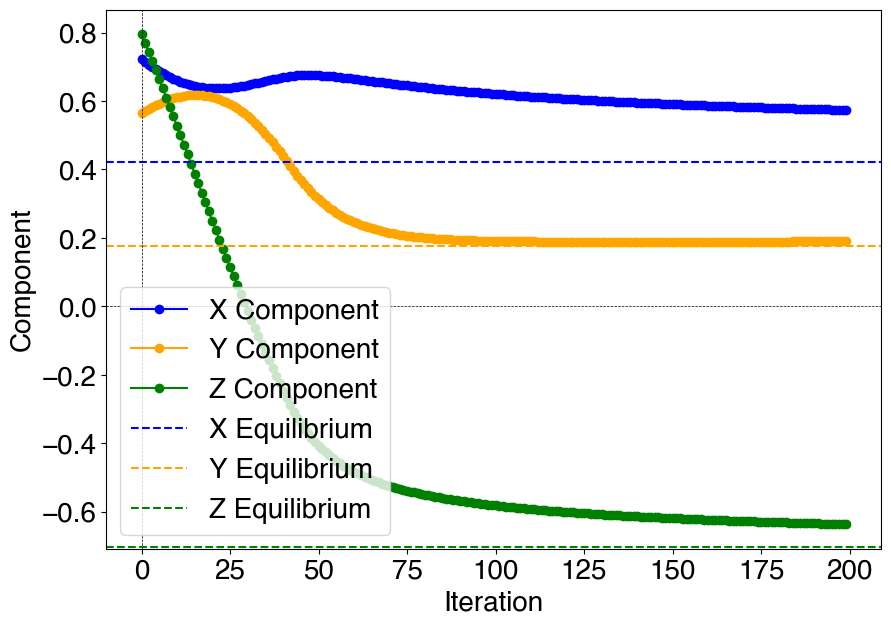

In [61]:
x_lst = [np.real(np.trace(vqe_sim.sigma_x @ rho_list[i].toarray())) for i in range(len(rho_list))]
y_lst = [np.real(np.trace(vqe_sim.sigma_y @ rho_list[i].toarray())) for i in range(len(rho_list))]
z_lst = [np.real(np.trace(vqe_sim.sigma_z @ rho_list[i].toarray())) for i in range(len(rho_list))]

plt.figure(figsize=(10, 7))
plt.plot(range(len(x_lst)), x_lst, label='X Component', color='blue', marker='o')
plt.plot(range(len(y_lst)), y_lst, label='Y Component', color='orange', marker='o')
plt.plot(range(len(z_lst)), z_lst, label='Z Component', color='green', marker='o')
plt.axhline(y = x_equilibrium, color='blue', linestyle='--', label='X Equilibrium')
plt.axhline(y = y_equilibrium, color='orange', linestyle='--', label='Y Equilibrium')
plt.axhline(y = z_equilibrium, color='green', linestyle='--', label='Z Equilibrium')
# plt.axhline(y = - x_equilibrium, color='blue', linestyle='--', label='X Equilibrium')
# plt.axhline(y = - y_equilibrium, color='orange', linestyle='--', label='Y Equilibrium')
# plt.axhline(y = - z_equilibrium, color='green', linestyle='--', label='Z Equilibrium')
plt.xlabel('Iteration')
plt.ylabel('Component')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.show()

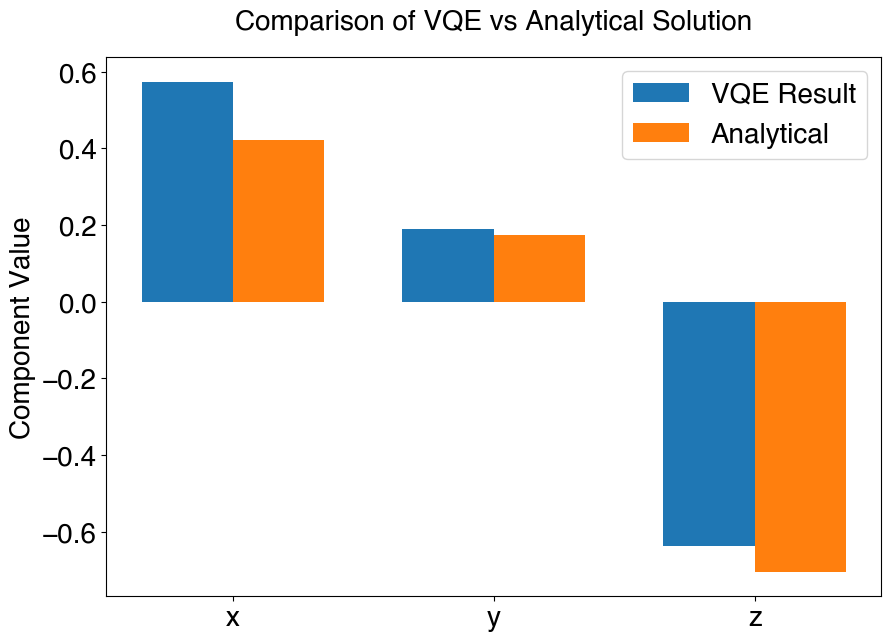

In [62]:
# Get the final density matrix components
rho_final = vqe_sim._unvectorize_rho(rho_list[-1])
x_final = np.real(rho_final[0, 1] + rho_final[1, 0])
y_final = np.imag(rho_final[1, 0] - rho_final[0, 1])
z_final = np.real(rho_final[0, 0] - rho_final[1, 1])

# Get analytical solutions
analytical_solutions = solution_set()

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 7))
components = ['x', 'y', 'z']
numerical_values = [x_final, y_final, z_final]
analytical_values = analytical_solutions[0]  # Using first solution set

x = np.arange(len(components))
width = 0.35

ax.bar(x - width/2, numerical_values, width, label='VQE Result')
ax.bar(x + width/2, analytical_values, width, label='Analytical')

ax.set_ylabel('Component Value')
ax.set_title('Comparison of VQE vs Analytical Solution')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()
plt.show()